In [1]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
import numpy as np
import sklearn
import sys, pickle, os, glob, re, math

if '../code' not in sys.path: sys.path.append('../code')

from em_gmm import *

dtype='float32'

In [2]:
# Verify that we get similar likelihoods with e step.

# Make sure N, D are small so the numerically unstable verification code
# doesn't underflow.
N = 5
D = 10

X = np.random.normal(size=(N, D))
mu = X.mean(axis=0)
sigma = X.std(axis=0)
mus = np.array([mu, mu, mu * 2])
sigmas = np.array([sigma, sigma * 2, sigma])
K = len(sigmas)
alphas = np.random.dirichlet(np.ones(K), 1)[0]

with tf.Session() as sess:
    mean_ll, resp = sess.run(estep(*(tf.constant(x) for x in (X, mus, sigmas, alphas))))
def normal_likelihoods(X, mu, sigma):
    exponent = -np.dot((X - mu[np.newaxis, :]) ** 2, 1 / sigma) / 2
    return (2 * np.pi) ** (-D / 2) * np.prod(sigma) ** (-1 / 2) * np.exp(exponent)
actual = np.array([normal_likelihoods(X, mu, sigma) for mu, sigma in zip(mus, sigmas)])
actual = sklearn.preprocessing.normalize(actual * alphas[:, np.newaxis], norm='l1', axis=0)
resp = sklearn.preprocessing.normalize(resp, norm='l1', axis=0)
print('actual likelihoods', actual)
print('log likelihoods   ', resp)
rmses = np.sqrt(sklearn.metrics.mean_squared_error(actual.T, resp.T, multioutput='raw_values'))
for i, rmse in enumerate(rmses):
    print('K={} rmse={}'.format(i, rmse))

actual likelihoods [[ 0.91053468  0.85783549  0.85152177  0.75222812  0.64428618]
 [ 0.02580634  0.01533914  0.01787783  0.02363273  0.08204466]
 [ 0.06365898  0.12682537  0.13060041  0.22413915  0.27366916]]
log likelihoods    [[ 0.91053468  0.85783549  0.85152177  0.75222812  0.64428618]
 [ 0.02580634  0.01533914  0.01787783  0.02363273  0.08204466]
 [ 0.06365898  0.12682537  0.13060041  0.22413915  0.27366916]]
K=0 rmse=2.579925170969555e-16
K=1 rmse=4.8844096046602074e-17
K=2 rmse=2.5438405243138006e-16


EM iteration 0 log likelihood -7.35198
EM iteration 1 log likelihood -6.47468
EM iteration 2 log likelihood -6.24675
EM iteration 3 log likelihood -5.97249
EM iteration 4 log likelihood -5.76791
EM iteration 5 log likelihood -5.58114
EM iteration 6 log likelihood -5.33878
EM iteration 7 log likelihood -5.1598
EM iteration 8 log likelihood -4.99779
EM iteration 9 log likelihood -4.9299
EM iteration 10 log likelihood -4.89467
EM iteration 11 log likelihood -4.89062
EM iteration 12 log likelihood -4.89026
EM iteration 13 log likelihood -4.89019
EM iteration 14 log likelihood -4.89017
EM iteration 15 log likelihood -4.89016
EM iteration 16 log likelihood -4.89016
EM iteration 17 log likelihood -4.89016
EM iteration 18 log likelihood -4.89016
EM iteration 19 log likelihood -4.89016
EM iteration 20 log likelihood -4.89016
EM iteration 21 log likelihood -4.89016
EM iteration 22 log likelihood -4.89016
EM iteration 23 log likelihood -4.89016
EM iteration 24 log likelihood -4.89016
means
[[ 20.

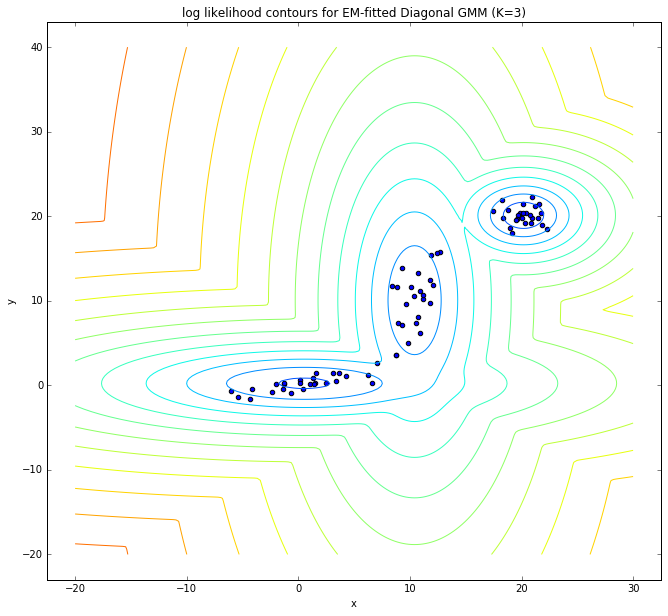

In [8]:
# Check that EM is working on small 2D example
# Note we intentionally shear the Gaussians to see how the model handles it.

n_samples = 25
np.random.seed(0)

def MVN(shear, shift):
    rs = np.random.randn(n_samples, 2)
    return (np.dot(rs, shear.T) + shift)
G1 = MVN(np.identity(2), np.array([20, 20]))
G2 = MVN(np.array([[0., 3.5], [-0.7, .7]]), np.zeros(2))
G3 = MVN(np.array([[-1, 0.8], [0, 4]]), np.array([10, 8]))

# concatenate the two datasets into the final training set
X = np.vstack([G1, G2, G3]).astype(dtype)
rx = np.random.choice(range(len(X)), 3, replace=False)

# http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html
_, m, s, a = fit_em(X, X[rx], 100, EPS, verbose=True)
x = np.linspace(-20.0, 30.0, 200)
y = np.linspace(-20.0, 40.0, 200)
xx, yy = np.meshgrid(x, y)
pts = np.array([xx.ravel(), yy.ravel()]).T.astype(dtype)
with tf.Session() as sess:
    ll = sess.run(-estep(pts, m, s, a)[0])
print('means\n{}\ncov\n{}\ncluster priors\n{}'.format(m, s, a))
plt.figure(figsize=(11, 10))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
#plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X[:, 0], X[:, 1])
plt.title('log likelihood contours for EM-fitted Diagonal GMM (K=3)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Make this into a nice image.
ys = [-10, 0, 2.5, 10, 20]
pts = np.arange(-20, 30, 0.1, dtype=dtype).reshape(-1, 1)
ys = np.array(ys, dtype=dtype).reshape(-1, 1)
# Reverse m, s, a, since we know 'y'
mr, sr = (x[:, ::-1] for x in (m, s))
plotmm, plotsm, plotlgams = marginal_posterior(ys, mr, sr, a)

mle_ys = np.arange(-20, 40, 0.1, dtype=dtype).reshape(-1, 1)
mm, sm, lgams = marginal_posterior(mle_ys, mr, sr, a)
ams = np.exp(lgams)
argmax_xs = [argmax_exp(mm, sm, am) for am in lgams]

mle_xs = argmax_xs # TODO implement fast version (or just do a single point est test?)

In [ ]:
print(ys)
plt.figure(figsize=(13, 10))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
with tf.Session() as sess:
    for i, y in enumerate(ys.reshape(-1)):
        lla = sess.run(estep(pts, plotmm, plotsm, np.exp(plotlgams[i]))[0]).reshape(-1)
        plt.plot(pts, np.exp(lla) * 10 + y, ls='-', c='black')

plt.plot(argmax_xs, mle_ys, label='argmax cluster mu', ls =':', c='blue', lw=2)
plt.plot(mle_xs, mle_ys, label='MLE', ls='--', c='red', lw=2, alpha=0.8)
plt.legend(bbox_to_anchor=(0., 1.02, 0.4, 1.02), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('GMM Marginal Posterior (K=3) x|y', loc='right')
plt.xlabel('x')
plt.ylabel('y (observed)')
plt.show()